# Imports

In [24]:
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
from textstat.textstat import textstat
from gensim.corpora import wikicorpus
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
%matplotlib inline
# Make it pretty
plt.style.use('ggplot')

# Read in data

In [25]:
file = '../data/enwiki.observations.text_wp10.30k.tsv'
raw_data = pd.read_csv(file, sep='\t', header=None)

In [5]:
data = pd.DataFrame(data=list(raw_data[0].apply(literal_eval)))
data = data[data['text'] != ""]
data = data[data['text'].str.contains("#redirect") == False]
data = data[data['text'].str.contains("may refer to:\n\n*") == False]
data = data[data['text'].str.contains("can refer to:\n") == False]
data = data[data['text'].str.contains("could refer to:\n") == False]
data = data[data['text'].str.contains("#REDIRECT") == False]
data = data[data['text'].str.contains("== Matches ==\n:") == False]
data = data[data['text'].str.contains("{{underconstruction") == False]

In [6]:
classes = {"stub": 0, "start": 1, "c": 2, "b": 3, "ga": 4, "fa": 5} 
data["label"] = data['label'].map(classes)

# Practice pipeline with part of data

In [11]:
data1000 = data[:200]

In [305]:
classes = {"stub": 0, "start": 1, "c": 2, "b": 3, "ga": 4, "fa": 5} 
data1000["label"] = data1000['label'].map(classes)
data1000

/Users/austin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,label,page_title,project,text,timestamp
0,5,Funerary art,visual arts,[[Image:GD-FR-Paris-Louvre-Sculptures034.JPG|3...,20100504203659
1,5,Battle of Warsaw (1920),russia,{{Infobox Military Conflict\n|conflict=Battle ...,20070111175847
2,2,Henry Digby (Royal Navy officer),biography,{{Use British English|date=August 2011}}\n{{Us...,20111205102850
3,2,Ottawa Redblacks,canadian football,{{Use mdy dates|date=May 2013}}\n{{Infobox CFL...,20140513220942
4,2,Qimonda,germany,{{Infobox_Company |\n company_name = Qimond...,20090315202104
5,1,"Ocracoke, North Carolina",project north carolina,{{Infobox Settlement\n|official_name ...,20080911150022
6,2,Erik Wilhelm,biography,{{construction}}\n\n{{Infobox NFL player\n| im...,20141125183748
7,0,Kolibite,bulgaria,{{Infobox settlement \n|official_name =Kolibit...,20120524063028
8,3,Edouard Borovansky,ballet,{{Infobox Person\n| name = Edouard Borovansk...,20110208153146
9,0,Jacek Wiśniewski,poland,{{Football player infobox\n| playername= Jacek...,20090105062145


# Random Forest Test

In [23]:
def clean_wiki_markup(raw_article):
    semi_cleaned_article = wikicorpus.filter_wiki(raw_article)
    cleaned_article = semi_cleaned_article.replace("\n", "").replace("\'", "").replace("()", "").replace("=", "").replace("|alt","").replace("\xa0","")
    return cleaned_article

def find_num_categories(raw_article):
    return raw_article.count("[[Category:")

def find_num_images(raw_article):
    return raw_article.count("[[Image:")

def find_num_ISBN(raw_article):
    return raw_article.count("ISBN")

def find_num_references(raw_article):
    return raw_article.count("</ref>")

def find_article_length(cleaned_article):
    return len(cleaned_article)

def find_num_difficult_words(cleaned_article):
    return textstat.difficult_words(cleaned_article)

def find_dale_chall_readability_score(cleaned_article):
    return textstat.dale_chall_readability_score(cleaned_article)

def find_automated_readability_index(cleaned_article):
    return textstat.automated_readability_index(cleaned_article)

def find_linsear_write_formula(cleaned_article):
    return textstat.linsear_write_formula(cleaned_article)

def find_gunning_fog_index(cleaned_article):
    return textstat.gunning_fog(cleaned_article)

def find_syllable_count(cleaned_article):
    return textstat.syllable_count(cleaned_article)

def find_lexicon_count(cleaned_article):
    return textstat.lexicon_count(cleaned_article, removepunct=True)

def find_sentence_count(cleaned_article):
    return textstat.sentence_count(cleaned_article)

def find_smog_index(cleaned_article):
    return textstat.smog_index(cleaned_article)

def find_num_web_citations(raw_article):
    return raw_article.count("{{cite web")

def find_num_book_citations(raw_article):
    return raw_article.count("{{cite book")

def find_num_news_citations(raw_article):
    return raw_article.count("{{cite news")

def find_num_note_tags(raw_article):
    return raw_article.count("{{note")

def find_num_quotes(raw_article):
    return raw_article.count("quote=")

def find_num_footnotes(raw_article):
    return raw_article.count("{{")

def find_num_h3_headers(raw_article):
    return raw_article.count("\n===")

def find_num_internal_links(raw_article):
    return (raw_article.count("[["))

def find_num_h2_headers(raw_article):
    return (raw_article.count("\n==") - find_num_h3_headers(raw_article))

In [307]:
data1000['num_web_citations'] = data1000['text'].apply(find_num_web_citations)
data1000['num_book_citations'] = data1000['text'].apply(find_num_book_citations)
data1000['num_news_citations'] = data1000['text'].apply(find_num_news_citations)
data1000['num_quotes'] = data1000['text'].apply(find_num_quotes)
data1000['num_h3_headers'] = data1000['text'].apply(find_num_h3_headers)
data1000['num_internal_links'] = data1000['text'].apply(find_num_internal_links)
data1000['num_h2_headers'] = data1000['text'].apply(find_num_h2_headers)
data1000['cleaned_text'] = data1000['text'].apply(clean_wiki_markup)
data1000['has_infobox'] = data1000['text'].str.contains('{{Infobox').astype(int)
data1000['num_categories'] = data1000['text'].apply(find_num_categories)
data1000['num_images'] = data1000['text'].apply(find_num_images)
data1000['num_ISBN'] = data1000['text'].apply(find_num_ISBN)
data1000['num_references'] = data1000['text'].apply(find_num_references)
data1000['article_length'] = data1000['text'].apply(find_article_length)
data1000['num_difficult_words'] = data1000['cleaned_text'].apply(find_num_difficult_words)
data1000['dale_chall_readability_score'] = data1000['cleaned_text'].apply(find_dale_chall_readability_score)
data1000['readability_index'] = data1000['cleaned_text'].apply(find_automated_readability_index)
data1000['linsear_write_formula'] = data1000['cleaned_text'].apply(find_linsear_write_formula)
data1000['gunning_fog_index'] = data1000['cleaned_text'].apply(find_gunning_fog_index)
data1000['smog_index'] = data1000['cleaned_text'].apply(find_smog_index)
data1000['syllable_count'] = data1000['cleaned_text'].apply(find_syllable_count)
data1000['lexicon_count'] = data1000['cleaned_text'].apply(find_lexicon_count)
data1000['sentence_count'] = data1000['cleaned_text'].apply(find_sentence_count)

/Users/austin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/austin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/austin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [308]:
data1000.dropna(inplace=True)

/Users/austin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [310]:
df1 = data1000.loc[:, ['has_infobox','num_categories','num_images','num_ISBN','num_references','article_length',
                 'num_difficult_words','dale_chall_readability_score','readability_index','linsear_write_formula',
                 'gunning_fog_index', 'num_web_citations','num_book_citations','num_news_citations',
                'num_quotes','num_h3_headers','num_internal_links', 'num_h2_headers', 'syllable_count',
                 'lexicon_count', 'sentence_count']]
y = data1000.label.values

# Test/Train Split

In [311]:
X_train, X_test, y_train, y_test = train_test_split(df1.values, y, test_size=0.20, random_state=910)

# Random Forrest

In [317]:
RF = RandomForestRegressor(n_estimators=2000, random_state=910, )

In [318]:
RF.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
           oob_score=False, random_state=910, verbose=0, warm_start=False)

In [319]:
predictions = RF.predict(X_test)

In [394]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, predictions)

0.7402852258333333

In [381]:
dataset = pd.DataFrame({'predictions':predictions, 'true_value':y_test})

In [386]:
violin_data = [dataset[dataset.true_value==i].predictions for i in range(0,6)]

KeyError: 0

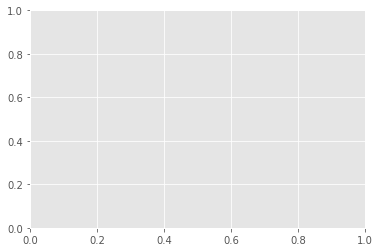

In [391]:
plt.violinplot(violin_data, showmeans=True)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('True vs. ALS Recommender Predicted Ratings')
plt.show()

array([5, 5, 2, ..., 3, 2, 3])

In [287]:
data['cleaned_text'] = data['text'].apply(clean_wiki_markup)
data['lexicon_count'] = data['cleaned_text'].apply(find_lexicon_count)
data['sentence_count'] = data['cleaned_text'].apply(find_sentence_count)
data['article_length'] = data['text'].apply(find_article_length)
data['num_difficult_words'] = data['cleaned_text'].apply(find_num_difficult_words)

In [222]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = '../data/glove.6B.50d.txt'
word2vec_output_file = 'glove.6B.50d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

(400001, 50)

In [ ]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = 'glove.6B.50d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [230]:
# calculate: (X - Z) + Y = ?
#result = model.most_similar(positive=['Y', 'X'], negative=['Z'], topn=1)
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

[('queen', 0.8523603677749634)]


In [266]:
from collections import Counter
article = Counter(wikicorpus.tokenize(data1000['cleaned_text'][0]))

In [263]:
from itertools import dropwhile
for key, count in dropwhile(lambda key_count: key_count[1] >= 20, article.most_common()):
    del article[key]

In [267]:
article2 - article

Counter()

In [16]:
data1000['cleaned_text'] = data1000['text'].apply(clean_wiki_markup)

/Users/austin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
from sklearn.feature_extraction.text import HashingVectorizer
hash_vectorizer = HashingVectorizer()
hash_vectorizer.fit(data1000['cleaned_text'])
X_transformed = hash_vectorizer.transform(data1000['cleaned_text'])
hash_df = pd.DataFrame(X_transformed.todense())
y = data1000.label.values
X_train, X_test, y_train, y_test = train_test_split(hash_df.values, y, test_size=0.20, random_state=910)
RF = RandomForestRegressor(n_estimators=500, random_state=910)
RF.fit(X_train, y_train)
predictions = RF.predict(X_test)
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, predictions)

KeyboardInterrupt: 

In [20]:
data1000.text.str.contains('{{').sum()

195

In [22]:
data1000[data1000.text.str.contains('{{') == False]

,label,page_title,project,text,timestamp,cleaned_text
18,3,Taoist sexual practices,taoism,"<div class=""floatright"">[[Image:Heqi.JPG|300px...",20061218195633,300pxAn ancient Chinese print depicting The Jo...
20,1,Adikavi Pampa,jainism,'''Pampa''' ([[Kannada]]: ಪಂಪ) born in [[902]]...,20070811185553,"Pampa (Kannada: ಪಂಪ) born in 902 C.E., also kn..."
36,1,Skewball,roots music/article scope,'''Skewball''' was the name of a British [[rac...,20080129031800,"Skewball was the name of a British racehorse, ..."
108,0,Eurydice of Mycenae,mythology,"In [[Greek Mythology]], '''Eurydice''' was the...",20080120030811,"In Greek Mythology, Eurydice was the daughter ..."
163,0,Aloe Plaza,st. louis,[[Image:Stlouis-waters.jpg|thumb|Aloe Plaza ac...,20100201005737,Aloe Plaza across Market from Union StationAlo...


In [83]:
#data[data['text'].str.contains("{{cn}}") == True]
#data[data['text'].str.contains("<s>") == True]
data[data['text'].str.contains('class="wikitable') == True]

,label,page_title,project,text,timestamp
0,5,Funerary art,visual arts,[[Image:GD-FR-Paris-Louvre-Sculptures034.JPG|3...,20100504203659
26,3,Line 4 Sheppard,trainswikiproject,{{Toronto_Subway_Lines}}\nThe '''Sheppard Line...,20061004191702
35,3,Bad Blood (2004),pro-wrestling,{{Infobox Wrestling event\n|name=Bad Blood (20...,20080819021204
44,3,Big Brother 5 (UK),big brother project,{{Big Brother endgame\n|seriesname = [[Big Bro...,20070217222201
47,5,List of basil cultivars,plants,<onlyinclude>This '''list of basil cultivars''...,20070308000252
52,2,Launceston Airport,aviation,{{Infobox Airport \n| name = Launcesto...,20080910222723
63,4,Puerto Rico at the 2008 Summer Olympics,puertoricoproj,{{Good article}} \n{{Infobox Olympics Puerto R...,20120808161551
72,4,Jordan Eberle,canada,{{Infobox Ice Hockey Player\n| team = [[Edmont...,20100124234019
74,3,1 Thing,r&b and soul music,{{for|the [[Finger Eleven]] song|One Thing}}\n...,20070705010711
82,4,Bethlehem,arab world,{{about|the city in the [[West Bank]]}}\n{{Inf...,20090626190656


In [84]:
def find_num_bullet_points(raw_article):
    return (raw_article.count('class="wikitable'))

In [86]:
find_num_bullet_points(data.text[8])

0